# Introduction

The idea behind the project is to create a simplified version of the semi-automatic offside. This is a technological implementation to reduce decision-making times regarding a possible offside. Offside in football occurs when the attacker receiving the ball is beyond the penultimate defender as the ball leaves the foot of the passing player.
To do this, there will be shown two techniques:


*   Detections of the players position, the players team, the players order and the position of the players to consider to understand if he is offside or not.
*   Learning with a CNN if the striker is in offside or not from a dataset of images.



# Create samples

The samples are composed as follows:


*   The background is green, it represents the playing field.
*   The white lines represent the field lines (areas, midfield etc.).
*   The players are represented by triangles, divided by teams (red and blue).
*   The ball is represented by a yellow circle.

The players are randomly generated on the pitch, but respecting the role criteria (on average 3 defenders in the first third of the pitch, 4 midfielders in the second third and 3 attackers in the last third, made to be more homogeneous and to simulate an action of real game).


## Import

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


## Global Variables

In [ ]:
#Images shape and channel
width = 1000
height = 600
channels = 3

#players features
num_players = 11 #for each team
attacking_team_color = (0, 0, 255)  # Red
defending_team_color = (255, 0, 0)   # Blue
min_distance = 30  # Minimum distance between players and between players and the ball

dataset_len = 10000

## Auxiliar functions

In [ ]:
def create_field():
  # Create an empty image to represent the soccer field
  field = np.ones((height, width, channels), dtype=np.uint8)
  field[:, :, 0] = 0
  field[:, :, 1] = 180
  field[:, :, 2] = 0

  # Draw the lines of the soccer field
  cv2.rectangle(field, (50, 50), (width - 50, height - 50), (255, 255, 255), 2)  # field
  cv2.line(field, (width // 2, 50), (width // 2, height - 50), (255, 255, 255), 2)  # center line
  cv2.circle(field, (width // 2, height // 2), 70, (255, 255, 255), 2)  # center circle
  cv2.rectangle(field, (150, height // 4), (50, height // 4 * 3 +10), (255, 255, 255), 2)  # left penalty area
  cv2.rectangle(field, (width - 150, height // 4), (width - 50, height // 4 * 3), (255, 255, 255), 2)  # right penalty area
  cv2.rectangle(field, (50, height // 4 + 100), (100, height // 4 * 3 - 100), (255, 255, 255), 2)  # left goal area
  cv2.rectangle(field, (width - 100, height // 4 + 100), (width - 50, height // 4 * 3 - 100), (255, 255, 255), 2)  # right goal area

  return field

# Position the players and the ball on the field
def place_players_and_ball(field, team_color, is_attacking, other_team = None):
    if other_team == None:
      players_pos = []
    else:
      players_pos = other_team
    ball_pos = None

    # X-coordinate limits for the different thirds of the field.
    second_third_x = (width // 3, 2 * width // 3)
    if team_color == (0, 0, 255):
      first_third_x = (100, width // 3)
      last_third_x = (2 * width // 3, width - 100)
    else:
      first_third_x =  (2 * width // 3, width - 100)
      last_third_x = (100, width // 3)

    for i in range(num_players):
        if i == 0: # Goalkeeper
            x = 80 if team_color == (0, 0, 255) else width - 80
            y = 300
        else:
            while True:
                if 1 <= i <= 3: #Defenders
                    x = np.random.randint(*first_third_x)
                elif 3 <= i <= 7: #Midfielders
                    x = np.random.randint(*second_third_x)
                else: #Strikers
                    x = np.random.randint(*last_third_x)

                y = np.random.randint(100, height - 100)

                # Check that the new position is not too close to the ball or to the other players.
                if ball_pos is None or np.sqrt((x - ball_pos[0]) ** 2 + (y - ball_pos[1]) ** 2) > min_distance:
                    too_close = False
                    for (px, py) in players_pos:
                        if np.sqrt((x - px) ** 2 + (y - py) ** 2) <= min_distance:
                            too_close = True
                            break
                    if not too_close:
                        break

            # Ball positioning
            if i == 2:
                ball_pos = (x + 25, y + 10)
                if is_attacking:
                    cv2.circle(field, ball_pos, 10, (0, 255, 255), -1)

        # Draw the player (as a triangle).
        points = np.array([[x, y - 15], [x - 15, y + 15], [x + 15, y + 15]], np.int32)
        cv2.fillPoly(field, [points], team_color)
        players_pos.append((x, y))

    return players_pos

def create_sample():
  field = create_field()
  attacking_players_pos = place_players_and_ball(field, attacking_team_color, is_attacking=True)
  defending_players_pos = place_players_and_ball(field, defending_team_color, is_attacking=False, other_team=attacking_players_pos)
  field = cv2.resize(field, (250, 150))

  return field

## Test

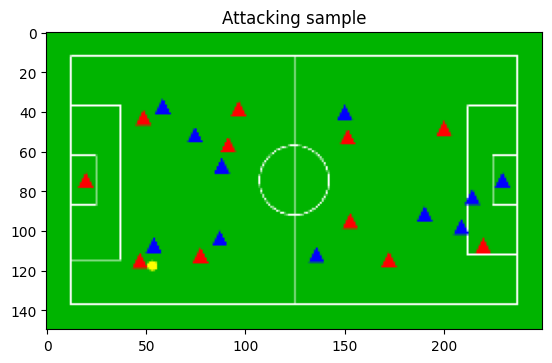

In [ ]:
field = create_sample()
plt.imshow(cv2.cvtColor(field, cv2.COLOR_BGR2RGB))
plt.title("Attacking sample")
plt.show()

# Create dataset

The dataset created have 10k samples (view global variables).

**RUN ONE TIME!**

In [ ]:
dst_path = "/content/drive/MyDrive/AIRO/Computer Vision/Offside Detection/Dataset"
for i in range(dataset_len):
  out_path = dst_path + "/img_"+str(i)+".png"
  sample = create_sample()
  cv2.imwrite(out_path, sample)